# Unit 5 - Financial Planning

In [42]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

import hvplot.pandas

%matplotlib inline

In [43]:
# Load .env enviroment variables
load_dotenv()

True

In [44]:
#Set number of trading days in a year as a global variable
TRADING_DAYS_PER_YEAR = 252

## Part 1 - Personal Finance Planner

In [45]:
# This function takes a dictionary of key-part value pairs and a list of column names, creates and returns a dataframe of parts
# Here, the parameter amount_of_parts is a dictionary; the index is set to be the keys
def create_dataframe(amount_of_parts, columns):
    parts_df = pd.DataFrame.from_dict(amount_of_parts, orient='index', columns=columns)
    return parts_df

In [46]:
# function that computes and returns the previous weekday from the current day
def get_previous_weekday():
    import datetime
    today = pd.Timestamp.today(tz="America/New_York")
    offset = max(1, (today.weekday() + 6) % 7 - 3)  # 7 days a week numbered 0 - 6. Four weekdays numbered 0-3
    timedelta = datetime.timedelta(offset)
    previous_week_day = today - timedelta
    return previous_week_day.normalize()

### Collect Crypto Prices Using the `requests` Library

In [47]:
# Set current amount of crypto assets
#my_btc = 1.2
#my_eth = 5.3
crypto_assets = {"btc": 1.2, "eth": 5.3}
crypto_df = create_dataframe(crypto_assets, ['quantity'])
my_btc = crypto_df.loc['btc','quantity']
my_eth = crypto_df.loc['eth','quantity']

In [48]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=USD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=USD"

In [49]:
# Fetch current BTC price
current_btc_price = requests.get(btc_url).json()['data']['1']['quotes']['USD']['price']

# Fetch current ETH price
current_eth_price = requests.get(eth_url).json()['data']['1027']['quotes']['USD']['price']

# Compute current value of my crpto
my_btc_value = my_btc * current_btc_price
my_eth_value = my_eth * current_eth_price

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $33421.20
The current value of your 5.3 ETH is $9350.42


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [50]:
# Set current amount of shares
current_amount_of_shares = {"SPY": 110, "AGG": 200}
shares_df = create_dataframe(current_amount_of_shares, ['shares'])
my_spy = shares_df.loc['SPY','shares']
my_agg = shares_df.loc['AGG','shares']

In [51]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
alpaca_api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [52]:
# Format current date as ISO format
previous_week_day = get_previous_weekday()  # get the last trading day
start_date = previous_week_day.isoformat()
end_date = start_date

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
ticker_data = alpaca_api.get_bars(
    tickers,
    timeframe,
    start = start_date,
    end = end_date
).df

# Reorganize the DataFrame
# Separate ticker data
AGG = ticker_data[ticker_data['symbol'] == 'AGG'].drop('symbol', axis=1)
SPY = ticker_data[ticker_data['symbol'] == 'SPY'].drop('symbol', axis=1)

# Concatenate the ticker DataFrames
ticker_data = pd.concat([AGG, SPY], axis=1, keys=tickers)

# Preview DataFrame
ticker_data

AGG                                              \
                             open    high    low   close   volume trade_count   
timestamp                                                                       
2023-03-24 04:00:00+00:00  100.28  100.49  99.95  100.16  6203977       23905   

                                           SPY                         \
                                 vwap     open    high    low   close   
timestamp                                                               
2023-03-24 04:00:00+00:00  100.145648  391.841  395.84  389.4  395.75   

                                                              
                              volume trade_count        vwap  
timestamp                                                     
2023-03-24 04:00:00+00:00  107053295      801995  393.110712

In [53]:
# Pick AGG and SPY close prices
agg_close_price = float(ticker_data["AGG"]["close"])
spy_close_price = float(ticker_data["SPY"]["close"])

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $100.16
Current SPY closing price: $395.75


In [54]:
# Compute the current value of shares
my_spy_value = my_spy * spy_close_price
my_agg_value = my_agg * agg_close_price

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 110 SPY shares is $43532.50
The current value of your 200 AGG shares is $20032.00


### Savings Health Analysis

In [55]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
financial_assets = {"crypto": my_btc_value + my_eth_value, "shares": my_spy_value + my_agg_value}

# Create savings DataFrame
df_savings = create_dataframe(financial_assets, ['amount'])

# Display savings DataFrame
display(df_savings)

,amount
crypto,42771.619
shares,63564.500


<AxesSubplot:title={'center':'Composition of Personal Savings'}, ylabel='amount'>

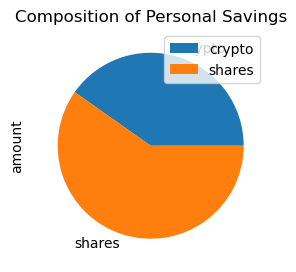

In [56]:
# Plot savings pie chart
df_savings['amount'].plot(kind='pie', figsize =(3, 5), legend=True, title="Composition of Personal Savings")

In [57]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_amount_of_savings = df_savings.sum()['amount']

# Validate saving health
if total_amount_of_savings > emergency_fund:
    print("Congratulations! You have enough money in your emergency fund.")
elif total_amount_of_savings == emergency_fund:
    print("Congratulations! You have reached an important financial goal.")
else:
    print(f"You are ${total_amount_of_savings - emergency_fund} away from reaching the financial goal.")

Congratulations! You have enough money in your emergency fund.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [58]:
# This function takes the number of years back from a given start date and returns the date back then
def get_past_date(start_date, years_from_start):
    day_distance = 365 * years_from_today
    date_back = start_date - pd.Timedelta(day_distance, unit="d")
    return date_back

In [59]:
# This function configures a Monte Carlo simulation to forecast a given horizon and returns the Monte Carlo distribution
# The following parameters are passed: stock dataframe (df),portfolio split as a list (weights), desired number of simulations (num_simulation)
# and the number of trading days (num_trading_days)
def configure_mc(df, weights, num_simulation, forecast_horizon):
    MC_dist = MCSimulation(
        portfolio_data = df,
        weights = weights,
        num_simulation = num_simulation,
        num_trading_days = TRADING_DAYS_PER_YEAR * forecast_horizon
    )
    return MC_dist

In [60]:
# This function takes a summary statistics table and calculates a 95% confidence interval on the expected portfolio returns for a given investment
def expected_portfolio_return(simulation_table, initial_investment, forecast_horizon):
    # Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of the initial investment
    ci_lower = round(sim_tbl['95% CI Lower']*initial_investment,2)
    ci_upper = round(sim_tbl['95% CI Upper']*initial_investment,2)
    message = f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio" \
      f" over the next {forecast_horizon} years will end within in the range of" \
      f" ${ci_lower} and ${ci_upper}"
    return message

In [61]:
# Get 5 years' worth of historical data for SPY and AGG
# Assume "today" is the date of the last trading day
years_from_today = 5
end_date = previous_week_day.isoformat()
start_date = get_past_date(previous_week_day, years_from_today).isoformat()
ticker_df = alpaca_api.get_bars(
    tickers,
    timeframe,
    start=start_date,
    end=end_date
).df

# Reorganize the DataFrame
# Separate ticker data
AGG = ticker_df[ticker_df['symbol']=='AGG'].drop(['symbol','trade_count', 'vwap'], axis=1)
SPY = ticker_df[ticker_df['symbol']=='SPY'].drop(['symbol', 'trade_count', 'vwap'], axis=1)

# Concatenate the ticker DataFrames
df_stock_data = pd.concat([AGG, SPY], axis=1, keys=tickers)

# Display sample data
df_stock_data.head()

AGG                                      SPY  \
                             open    high     low   close   volume    open   
timestamp                                                                    
2018-03-26 04:00:00+00:00  106.64  106.71  106.47  106.57  4546535  262.13   
2018-03-27 04:00:00+00:00  106.63  106.95  106.61  106.88  4566884  266.17   
2018-03-28 04:00:00+00:00  107.05  107.10  106.88  106.94  5617206  260.75   
2018-03-29 04:00:00+00:00  106.95  107.26  106.95  107.25  9199453  261.12   
2018-04-02 04:00:00+00:00  106.90  107.04  106.82  106.90  7280259  262.55   

                                                                
                             high       low   close     volume  
timestamp                                                       
2018-03-26 04:00:00+00:00  265.43  259.4100  265.14  143141239  
2018-03-27 04:00:00+00:00  266.77  258.8400  260.76  130806695  
2018-03-28 04:00:00+00:00  262.64  258.5800  259.85  146510333  
2018-03-29 04:00:00+00:00  265.26  259.8389  263.43  125470572  
2018-04-02 04:00:00+00:00  263.13  254.6700  257.52  186324337

In [62]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
num_sims = 500
weights = [.4,.6]
forecast_horizon = 30

MC_traditional_dist = configure_mc(df_stock_data, weights, num_sims, forecast_horizon)


In [63]:
# Printing the simulation input data
MC_traditional_dist.portfolio_data.head()

AGG                                   \
                             open    high     low   close   volume   
timestamp                                                            
2018-03-26 04:00:00+00:00  106.64  106.71  106.47  106.57  4546535   
2018-03-27 04:00:00+00:00  106.63  106.95  106.61  106.88  4566884   
2018-03-28 04:00:00+00:00  107.05  107.10  106.88  106.94  5617206   
2018-03-29 04:00:00+00:00  106.95  107.26  106.95  107.25  9199453   
2018-04-02 04:00:00+00:00  106.90  107.04  106.82  106.90  7280259   

                                           SPY                            \
                          daily_return    open    high       low   close   
timestamp                                                                  
2018-03-26 04:00:00+00:00          NaN  262.13  265.43  259.4100  265.14   
2018-03-27 04:00:00+00:00     0.002909  266.17  266.77  258.8400  260.76   
2018-03-28 04:00:00+00:00     0.000561  260.75  262.64  258.5800  259.85   
2018-03-29 04:00:00+00:00     0.002899  261.12  265.26  259.8389  263.43   
2018-04-02 04:00:00+00:00    -0.003263  262.55  263.13  254.6700  257.52   

                                                   
                              volume daily_return  
timestamp                                          
2018-03-26 04:00:00+00:00  143141239          NaN  
2018-03-27 04:00:00+00:00  130806695    -0.016520  
2018-03-28 04:00:00+00:00  146510333    -0.003490  
2018-03-29 04:00:00+00:00  125470572     0.013777  
2018-04-02 04:00:00+00:00  186324337    -0.022435

In [64]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_traditional_dist.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Fintech\ASU-VIRT-FIN-PT-02-2023-U-LOLC\02-Homework\04-module5\APIs_and_financial_simulations\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.008622,0.991910,0.995610,1.011399,0.984940,0.992372,0.995091,0.997082,1.002209,1.000697,...,1.006734,0.999738,0.994990,0.997160,0.985192,1.000749,0.999613,1.011182,0.994253,1.002271
2,1.012638,0.978798,1.004685,1.016530,0.996470,0.994937,0.988265,1.001895,1.001097,1.008951,...,0.997627,0.997486,1.003127,0.993274,0.996302,1.005272,0.984656,1.008689,0.990934,1.007828
3,1.010852,0.979887,1.008694,1.023481,0.995380,0.997014,1.002334,1.011419,0.998215,1.006850,...,0.978751,1.008036,0.995235,0.999333,0.988658,1.005271,0.985541,0.999115,0.979086,0.999759
4,1.020444,0.988377,0.994272,1.036688,0.983029,0.997684,1.000710,0.996138,1.000015,1.011024,...,0.984893,1.004769,0.992977,0.992455,0.986791,0.996567,0.968804,0.988315,0.984765,0.995542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,8.156674,6.351801,11.933804,2.796540,1.463794,2.454170,3.029819,0.965704,4.591696,7.804331,...,10.270107,7.669909,1.467948,4.086180,12.883475,2.013504,10.423162,2.571997,1.850476,5.804341
7557,8.144040,6.404091,12.004461,2.772563,1.470002,2.457169,3.034828,0.981387,4.590623,7.741863,...,10.229107,7.598156,1.479259,4.128027,13.005876,2.009770,10.380164,2.555170,1.839396,5.762028
7558,8.141457,6.356873,12.015385,2.755910,1.455388,2.432777,3.027852,0.983297,4.624775,7.683682,...,10.173340,7.581419,1.466424,4.177172,13.077806,2.003217,10.438107,2.565057,1.792567,5.741398
7559,8.052909,6.435223,12.052351,2.730209,1.447926,2.437353,3.017563,0.986733,4.624028,7.736042,...,10.154585,7.503987,1.466912,4.186784,13.164032,2.009944,10.349677,2.577128,1.809398,5.689605


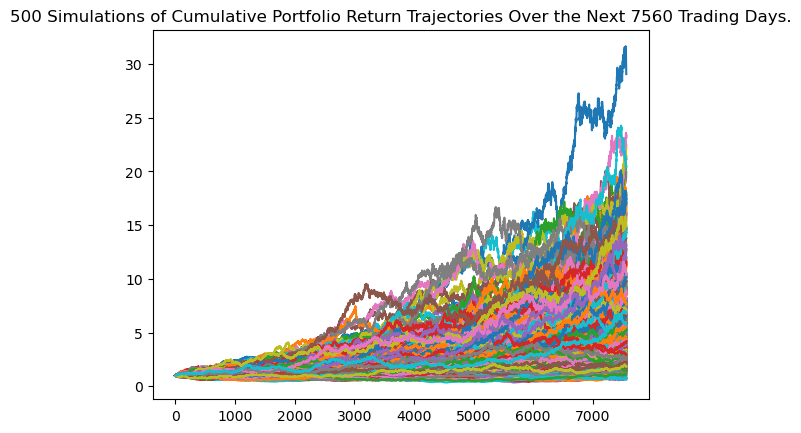

In [65]:
# Plot simulation outcomes
line_plot = MC_traditional_dist.plot_simulation()

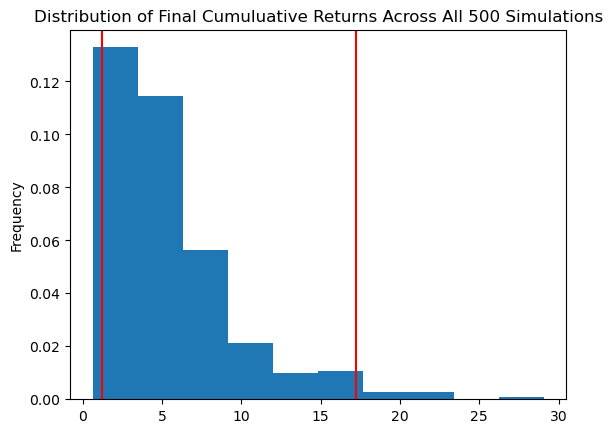

In [66]:
# Plot probability distribution and confidence intervals
dist_plot = MC_traditional_dist.plot_distribution()

### Retirement Analysis

In [67]:
# Fetch summary statistics from the Monte Carlo simulation results
sim_tbl = MC_traditional_dist.summarize_cumulative_return()

# Print summary statistics
print(sim_tbl)

count           500.000000
mean              5.471287
std               4.139776
min               0.623406
25%               2.711992
50%               4.288859
75%               6.801369
max              29.064724
95% CI Lower      1.198768
95% CI Upper     17.216397
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [68]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
#ci_lower = round(sim_tbl['95% CI Lower']*initial_investment,2)
#ci_upper = round(sim_tbl['95% CI Upper']*initial_investment,2)

# Print results
#print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
#      f" over the next 30 years will end within in the range of"
#      f" ${ci_lower} and ${ci_upper}")
print(expected_portfolio_return(sim_tbl, initial_investment, forecast_horizon))

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $23975.36 and $344327.94


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [69]:
# Set initial investment
initial_investment = 20000 * 1.5

print(expected_portfolio_return(sim_tbl, initial_investment, forecast_horizon))

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $35963.03 and $516491.91


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [70]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
num_sims = 500
early_horizon = 5
weights = [.2,.8]  # 20% bonds (AGG) and 80% stocks (SPY)

MC_early_dist = configure_mc(df_stock_data, weights, num_sims, early_horizon)
MC_early_dist.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Fintech\ASU-VIRT-FIN-PT-02-2023-U-LOLC\02-Homework\04-module5\APIs_and_financial_simulations\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.990284,1.001983,1.011665,1.014125,1.022702,0.998590,0.999649,1.006178,0.993243,0.999130,...,0.992929,1.010393,0.999900,0.993934,1.008378,0.996532,1.015993,0.999349,0.992844,0.992594
2,1.003221,1.008845,1.026110,1.026237,1.015508,0.967905,0.999522,0.995513,0.997867,0.985471,...,0.994615,1.033670,1.004207,0.987278,1.003355,0.992520,1.003643,1.003116,0.985877,0.998186
3,1.009852,0.995420,1.023668,1.038598,1.003048,0.965255,1.009645,0.987506,0.988638,0.999697,...,0.985202,1.026540,1.012101,0.992335,1.016940,0.986699,1.000410,0.998782,0.995172,0.979302
4,1.017182,0.993895,1.017737,1.040067,1.010962,0.958030,1.012791,0.996716,0.990617,0.994635,...,0.980317,1.035664,1.014528,0.987132,1.027119,0.975709,0.998680,1.001062,0.979620,0.963538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.672236,0.990084,1.565517,1.383849,1.935773,1.328516,1.138714,1.338282,1.147968,0.799160,...,1.279613,1.443007,2.545210,1.017612,1.095720,1.574770,2.417764,0.624773,0.615009,1.484855
1257,1.645492,0.975649,1.566829,1.375420,1.953468,1.333331,1.133745,1.345112,1.136106,0.790205,...,1.277337,1.463049,2.510724,1.007392,1.082672,1.560972,2.435968,0.618210,0.624279,1.489052
1258,1.628197,0.982726,1.563195,1.368020,1.980588,1.345703,1.139209,1.319480,1.152203,0.803204,...,1.246011,1.459622,2.536633,0.982239,1.081158,1.574995,2.422885,0.619260,0.624477,1.474386
1259,1.639223,0.977512,1.591438,1.358777,1.962847,1.313779,1.141935,1.325897,1.141746,0.788880,...,1.239731,1.449842,2.512152,0.975669,1.094074,1.558220,2.431613,0.619351,0.623748,1.484092


In [71]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_early_dist.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Fintech\ASU-VIRT-FIN-PT-02-2023-U-LOLC\02-Homework\04-module5\APIs_and_financial_simulations\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.024432,1.000784,0.990894,1.012929,0.995786,1.006367,1.000345,1.015350,1.013384,0.999506,...,0.980747,0.996220,1.012152,0.995283,1.008588,1.008837,1.009032,1.014772,0.996761,1.006263
2,1.038451,1.004281,1.008431,1.020579,1.020761,1.001876,1.003064,1.014462,0.998868,0.982236,...,0.991777,0.991115,1.009000,0.994848,1.010090,1.001896,1.007259,1.030626,1.007998,0.993828
3,1.056567,0.992282,1.018251,1.009739,1.014548,0.991671,0.995211,1.022779,1.000692,0.981570,...,1.001930,0.977900,1.014719,0.978424,1.014773,1.004674,1.022520,1.032016,0.996805,0.989001
4,1.070516,0.997193,1.026270,1.003299,1.008810,1.001001,0.987815,1.031514,0.993141,0.997227,...,0.999448,0.966397,1.018590,0.983652,1.010246,0.994696,1.009810,1.036262,0.994092,0.984745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.424639,1.838971,0.736467,2.237388,1.363446,1.876049,1.412162,1.858455,1.760643,2.127229,...,3.270053,1.630470,1.028230,1.054036,2.754230,1.317227,1.160161,1.759934,0.657924,1.746587
1257,1.433886,1.861794,0.739371,2.202290,1.369907,1.882308,1.413672,1.843901,1.788088,2.129772,...,3.302451,1.637228,1.042003,1.072378,2.785026,1.312730,1.154643,1.780493,0.646872,1.738852
1258,1.449288,1.854872,0.746490,2.236596,1.359929,1.861749,1.448131,1.801833,1.744003,2.143910,...,3.308254,1.679977,1.054827,1.083748,2.807682,1.315779,1.160052,1.770687,0.644563,1.749005
1259,1.433686,1.861097,0.748831,2.225858,1.350712,1.835261,1.459948,1.830030,1.733648,2.166373,...,3.262187,1.664266,1.043992,1.081749,2.820654,1.302712,1.149295,1.792579,0.648241,1.780548


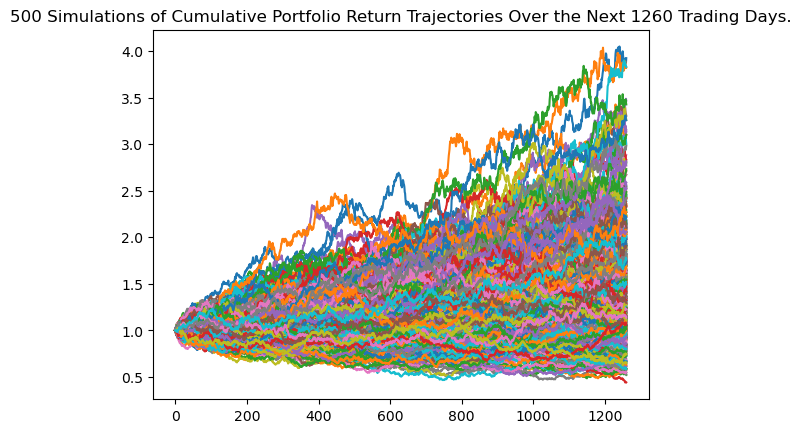

In [72]:
# Plot simulation outcomes
line_plot = MC_early_dist.plot_simulation()

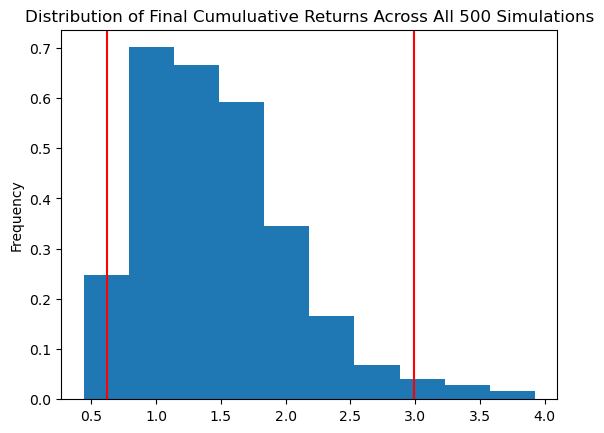

In [73]:
# Plot probability distribution and confidence intervals
dist_plot = MC_early_dist.plot_distribution()

In [74]:
# Fetch summary statistics from the Monte Carlo simulation results
early_sim_tbl = MC_early_dist.summarize_cumulative_return()

# Print summary statistics
print(early_sim_tbl)

count           500.000000
mean              1.484876
std               0.597998
min               0.441791
25%               1.042698
50%               1.385487
75%               1.790515
max               3.923563
95% CI Lower      0.617418
95% CI Upper      2.992232
Name: 1260, dtype: float64


In [75]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate and print the range of the possible outcomes of our $60,000
print(expected_portfolio_return(early_sim_tbl, initial_investment, early_horizon))

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years will end within in the range of $71926.07 and $1032983.81


### Ten Years Retirement Option

In [76]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
num_sims = 500
weights = [.2,.8]  # 20% bonds (AGG) and 80% stocks (SPY)
early_10y_horizon = 10  # 10 years cum returns

MC_10y_dist = configure_mc(df_stock_data, weights, num_sims, early_10y_horizon)

In [77]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_10y_dist.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Fintech\ASU-VIRT-FIN-PT-02-2023-U-LOLC\02-Homework\04-module5\APIs_and_financial_simulations\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.996873,1.005321,1.005494,0.979441,1.020114,1.003553,1.006718,1.001695,1.011518,0.990576,...,1.005480,0.989292,1.021896,1.001897,1.007542,0.995778,1.017655,1.013010,1.001208,1.012004
2,1.005182,0.996231,1.015012,0.968410,1.030085,1.007470,1.017886,1.025735,0.998962,1.009382,...,1.003226,0.995983,1.015097,0.997049,1.006526,0.988369,1.024149,1.004608,1.001581,1.030289
3,1.012820,0.991919,1.018679,0.948565,1.038524,1.004951,1.028368,1.033121,0.990544,1.008576,...,0.990067,0.985420,1.025944,1.017010,1.003439,0.978050,1.011826,1.006218,1.007908,1.036533
4,1.009577,0.995595,1.008011,0.949943,1.027242,1.005868,1.037512,1.007983,0.991192,1.019636,...,0.990963,0.977475,1.025776,1.041682,1.020611,0.973280,1.012073,1.014335,0.986728,1.037364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,3.827233,1.559245,1.183532,1.097918,1.899673,1.524209,3.266420,1.967365,1.050436,1.511374,...,1.781888,2.272942,3.129425,3.323184,3.001026,0.954414,5.098348,3.329088,1.016020,2.052756
2517,3.901984,1.568666,1.178265,1.088841,1.906887,1.518963,3.311812,1.967332,1.052885,1.504930,...,1.767672,2.267608,3.139218,3.315277,2.998645,0.948412,5.136676,3.390180,1.031785,2.056072
2518,3.914331,1.588681,1.183847,1.096794,1.877658,1.543783,3.341198,1.960217,1.045651,1.479931,...,1.748241,2.221910,3.096088,3.341313,3.013738,0.933906,5.124035,3.417307,1.037438,2.053343
2519,3.919146,1.575273,1.201373,1.109571,1.930704,1.538100,3.359002,1.934725,1.059074,1.483413,...,1.717332,2.238351,3.157242,3.344737,3.051903,0.932977,5.074601,3.415144,1.032198,2.056252


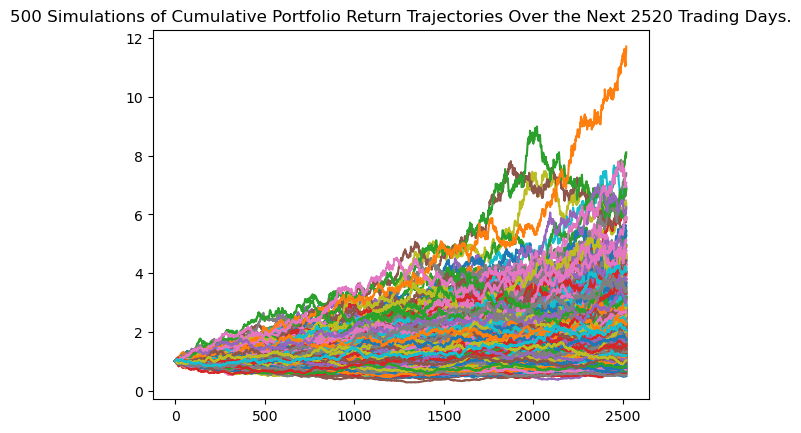

In [78]:
# Plot simulation outcomes
line_plot = MC_10y_dist.plot_simulation()

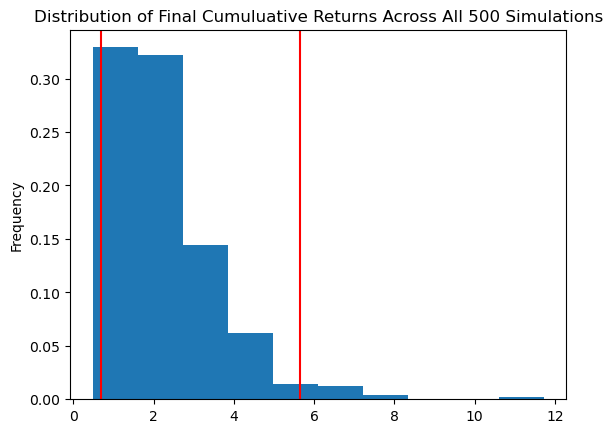

In [79]:
# Plot probability distribution and confidence intervals
dist_plot = MC_10y_dist.plot_distribution()

In [80]:
# Fetch summary statistics from the Monte Carlo simulation results
sim_tbl_10y = MC_10y_dist.summarize_cumulative_return()

# Print summary statistics
print(sim_tbl_10y)

count           500.000000
mean              2.247814
std               1.328119
min               0.486877
25%               1.320389
50%               1.935049
75%               2.853806
max              11.722505
95% CI Lower      0.678812
95% CI Upper      5.650874
Name: 2520, dtype: float64


In [81]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate and print the range of the possible outcomes of our $60,000
print(expected_portfolio_return(sim_tbl_10y, initial_investment, early_10y_horizon))

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within in the range of $71926.07 and $1032983.81
